# HW2 Report

## 1: [20pt]
Allowed libraries: pandas, numpy

(a) Split the dataset 70:30 for training and testing respectively.

(b) Use your solution to regress weight (dependent variable) on each of the 7 non-car_name features (independent variables). Do this for the 0th to 3rd order of the independent variables.

(c) Calculate the training and testing mean squared errors for each variable and order individually.

(d) Plot the lines and data for the testing set, one plot per variable (so 4 lines in each plot, 7 plots total). Which polynomial order performs the best in the test set?

(e) Repeat your analysis using an 80:20 train:test split. How does your answer change?

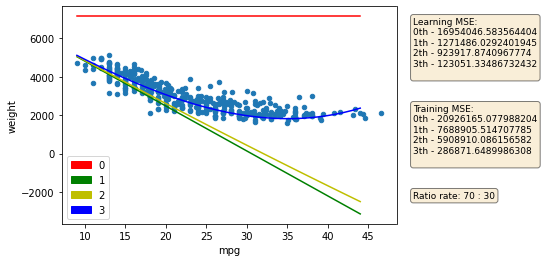

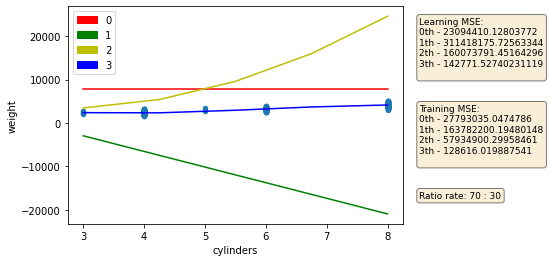

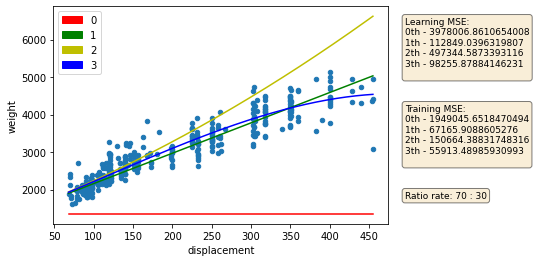

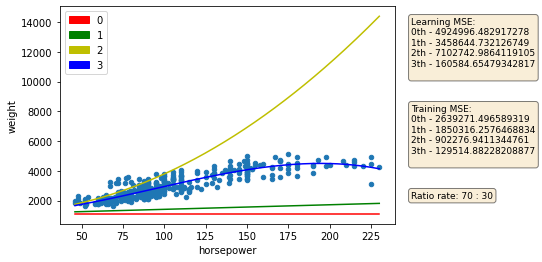

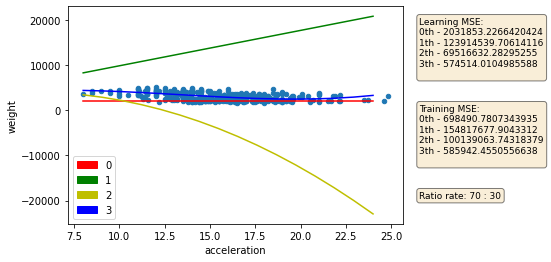

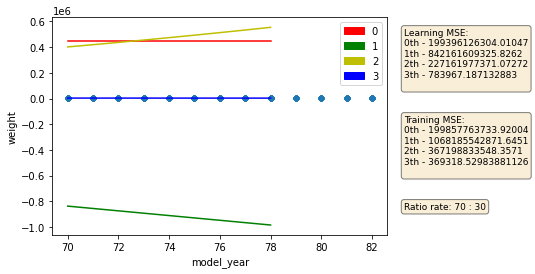

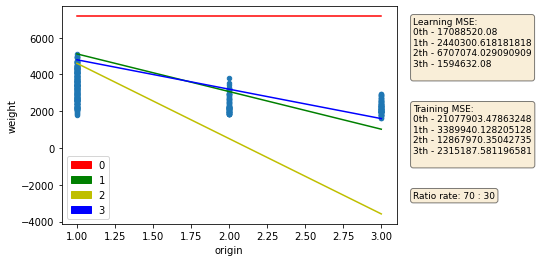

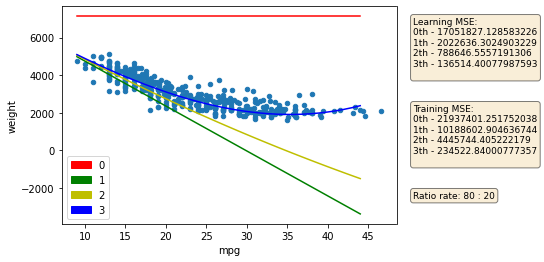

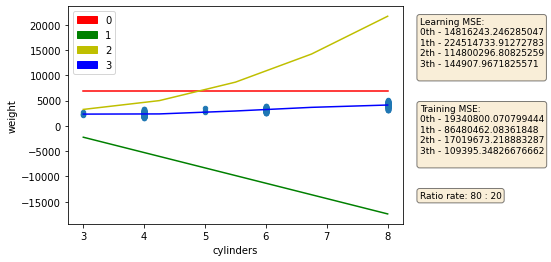

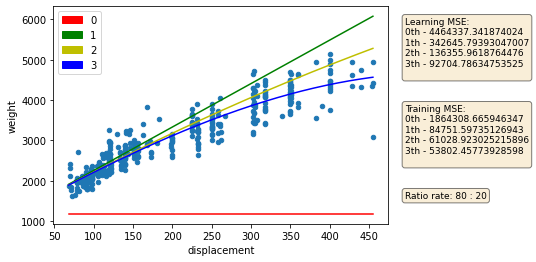

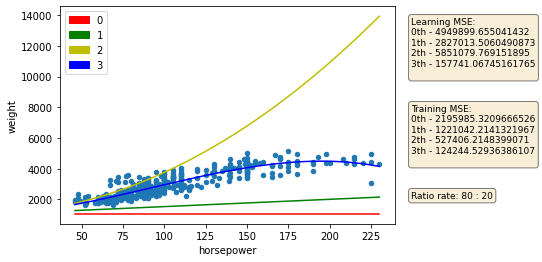

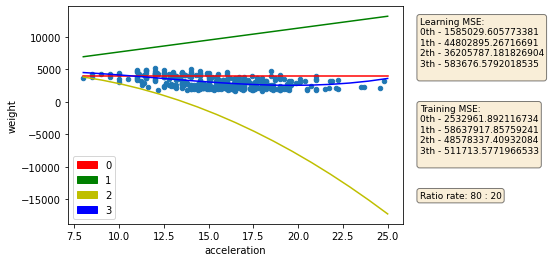

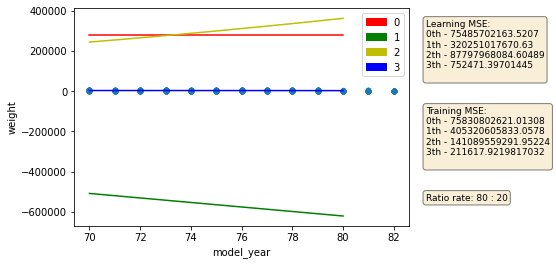

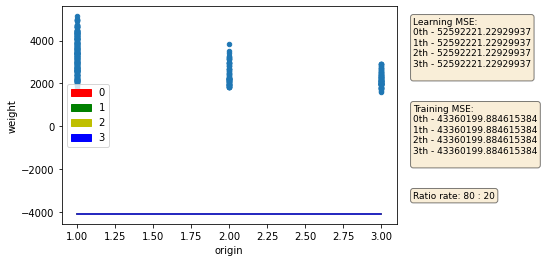

In [426]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches



df = pd.read_csv('../datasets/auto-mpg.data', delim_whitespace=True, names=['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name'])

#drop rows with '?' in the horsepower column
df.drop(df[df['horsepower']=='?'].index,inplace=True)
df = df.reset_index()
del df['index']

#change horsepower type
df['horsepower']=df['horsepower'].astype('float64')
df.dtypes

#fixing data errors
df.replace('vokswagen','volkswagen',inplace=True)
df.replace('vw','volkswagen',inplace=True)
df.replace('toyouta','toyota',inplace=True)
df.replace('mercedes','mercedes-benz',inplace=True)
df.replace('maxda','mazda',inplace=True)
df.replace('chevroelt','chevrolet',inplace=True)
df.replace('chevy','chevrolet',inplace=True)
df.replace('hi','ih',inplace=True)

# Linear Regression class
class LinearRegression:

    # pass the dataframe in the constructor
    def __init__(self, df, split):
        self.b = []
        self.df = df
        self.split = split

    # this function fits a polynomial until the needed order
    def fit(self, x_in, y_in, order):
        
        # (a)
        x = np.array(self.df[x_in][:math.ceil(self.df.shape[0]*self.split)])
        y = np.array(self.df[y_in][:math.ceil(self.df.shape[0]*self.split)])
        x_test = np.array(self.df[x_in][math.ceil(self.df.shape[0]*self.split):])
        y_test = np.array(self.df[y_in][math.ceil(self.df.shape[0]*self.split):])

        
        X = np.c_[np.ones(len(x))]
        
        for i in range(1, order+1):
            X = np.c_[X, np.power(x, i)]
        
        # OLS
        self.b = np.linalg.inv(X.T@X)@(X.T@y)

        # visualize the data
        colors = {
            0: "r",
            1: "g",
            2: "y",
            3: "b"
        }   
        ax = self.df.plot.scatter(x=x_in, y=y_in)
        red_patch = mpatches.Patch(color='red', label='0')
        green_patch = mpatches.Patch(color='green', label='1')
        yellow_patch = mpatches.Patch(color='y', label='2')
        blue_patch = mpatches.Patch(color='b', label='3')
        plt.legend(handles=[red_patch,green_patch,yellow_patch,blue_patch])
        fieldLearning = "Learning MSE:\n"
        fieldTraining = "Training MSE:\n"

        for order_i in range (0, order+1):
            fx = np.linspace(math.floor(x.min()), math.ceil(x.max()), math.ceil(x.max())-math.floor(x.min()))
            if order_i == 0:
                fy = np.full((fx.size , 1), self.b[0])
            else:
                fy = self.b[0]
                for i in range(1, order_i+1):
                    fy += self.b[i] * np.power(fx, i) 

            # (d)
            ax.plot(fx, fy, colors[order_i])
            
            # (c)
            fieldLearning += str(order_i) + "th - " + str(self.mse(y, self.predict(x, order_i))) + "\n"
            fieldTraining += str(order_i) + "th - " + str(self.mse(y_test, self.predict(x_test, order_i))) + "\n"
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        ax.text(1.05, 0.95, fieldLearning, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=props)
        ax.text(1.05, 0.55, fieldTraining, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=props)
        ax.text(1.05, 0.15, "Ratio rate: " + str(int(self.split*100)) + " : " + str(int(100-self.split*100)), transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=props)

        
    # predict function uses the test portion of the data and outputs the results and the error
    def predict(self, x_in, order):
        # (a)
        # x_test = np.array(df[x_in][math.ceil(self.df.shape[0]*self.split):])
        pred = np.empty(x_in.size)
        for i in range(x_in.size):
            pred_temp = self.b[0]
            for j in range(1, order+1):
                pred_temp += self.b[j] * np.power(x_in[i], j)
            pred[i] = pred_temp
        return pred

    def mse(self,y_test,prediction):
        # (a)
        # y_test = np.array(df[y_in][math.ceil(self.df.shape[0]*self.split):])
        s = 0
        for i in range(len(y_test)):
            s+=(y_test[i]-prediction[i])**2
        score = s/len(y_test)
        return score



def procedure_1(ratio):

    # (b) & (d)
    lr = LinearRegression(df, ratio)
    for col in df.columns:
        if (col != 'weight') and (col != 'car_name'):
            lr.fit(col, 'weight', 3)
                
procedure_1(0.7)

# (e)
procedure_1(0.8)
    

## 2: [10pt]
Allowed libraries: pandas, scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html )

(a) Using logistic regression (1st order), perform classification on the various classes (light/medium/heavy). Create one regression model per feature.

(b) Report the training/testing classification performance using both precision and recall. For this classification task, give an example and explain when each of the metrics would be more desirable.

In [427]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

# we need to determine the range for each bin so they are equaly sized(all(3) the bins should have equal width)
# Equal Width Binning : bins have equal width with a range of each bin are defined as [min + w], [min + 2w] …. [min + nw] where w = (max – min) / (no of bins).
maxW = max(df['weight'])
minW = min(df['weight'])
width = (maxW - minW) / 3

# now the ranges for the weight classification are
lightMin = minW
lightMax = lightMin + math.floor(width)
mediumMin = lightMin + math.ceil(width)
mediumMax = mediumMin + math.floor(width)
heavyMin = mediumMin + math.ceil(width)
heavyMax = heavyMin + math.floor(width)

# set up the conditions
conditions = [
    ( df['weight'] >= lightMin ) & ( df['weight'] <= lightMax ),
    ( df['weight'] >= mediumMin ) & ( df['weight'] <= mediumMax ),
    ( df['weight'] >= heavyMin ) & ( df['weight'] <= heavyMax ),
]

# initialize a value for each condition
values = ['light', 'medium', 'heavy']

# create new column with conditioned values
df['weight_class'] = np.select(conditions, values)

# (a)

lr = LogisticRegression()
Y = df['weight_class'] # y  

for col in df.columns:
        if (col != 'weight') and (col != 'car_name') and (col != 'weight_class'):
            X = df[[col]] # 1 feature
            x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3)     
            lr.fit(x_train, y_train)

            # (b)
            print(col, " Training Scores")
            y_pred = lr.predict(np.array(x_train))
            print(col, " Precision: ", precision_score(y_train, y_pred, average='macro', zero_division=0))
            print(col, " Recall: ", recall_score(y_train, y_pred, average='macro', zero_division=0))

            print(col, " Testing Scores")
            y_pred = lr.predict(np.array(x_test))
            print(col, " Precision: ", precision_score(y_test, y_pred, average='macro', zero_division=0))
            print(col, " Recall: ", recall_score(y_test, y_pred, average='macro', zero_division=0))







mpg  Training Scores
mpg  Precision:  0.7945803031513892
mpg  Recall:  0.8041854909902892
mpg  Testing Scores
mpg  Precision:  0.7010424070125563
mpg  Recall:  0.6993132476739033
cylinders  Training Scores
cylinders  Precision:  0.8042012420393748
cylinders  Recall:  0.8355649518440216
cylinders  Testing Scores
cylinders  Precision:  0.8433641975308642
cylinders  Recall:  0.873015873015873
displacement  Training Scores
displacement  Precision:  0.8173143238932713
displacement  Recall:  0.7932908536731706
displacement  Testing Scores
displacement  Precision:  0.8025168025168025
displacement  Recall:  0.7728354978354979
horsepower  Training Scores
horsepower  Precision:  0.721555941770327
horsepower  Recall:  0.7309945520435837
horsepower  Testing Scores
horsepower  Precision:  0.7361632596300932
horsepower  Recall:  0.7225108225108224
acceleration  Training Scores
acceleration  Precision:  0.3471213692946058
acceleration  Recall:  0.44819235426396814
acceleration  Testing Scores
acceler

### 2.b continued

Precision is also called positive predictive value and can be interpreted as probability of a randomly selected object from a collection of objects is relevant. Example: in tumor detection algorithm the measurement of precision will use True Positive and False Positive values to find out how correct is the prediction.

Recall is also called as sensitivity and can be interpreted as probability of a randomly selected object from a collection of objects is actually received. Example: in tumor detection algorithm recall score will use True Positive and False Negative values to show the rate of correct identification of the actual positives

## 3: [5pt]
Allowed libraries: pandas, scikit-learn

(a) Re-do the logistic regression training/testing, but now after you apply min-max normalization to the dataset. Do you see any difference in performance?

In [428]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 

lr = LogisticRegression()
Y = df['weight_class'] # y  

for col in df.columns:
        if (col != 'weight') and (col != 'car_name') and (col != 'weight_class'):

            # the actual scaling
            X = scaler.fit_transform(df[[col]]) # 1 feature
            x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3)     
            lr.fit(x_train, y_train)

            print(col, " Training Scores")
            y_pred = lr.predict(np.array(x_train))
            print(col, " Precision: ", precision_score(y_train, y_pred, average='macro', zero_division=0))
            print(col, " Recall: ", recall_score(y_train, y_pred, average='macro', zero_division=0))

            print(col, " Testing Scores")
            y_pred = lr.predict(np.array(x_test))
            print(col, " Precision: ", precision_score(y_test, y_pred, average='macro', zero_division=0))
            print(col, " Recall: ", recall_score(y_test, y_pred, average='macro', zero_division=0))



mpg  Training Scores
mpg  Precision:  0.7352841391009329
mpg  Recall:  0.5821403006442377
mpg  Testing Scores
mpg  Precision:  0.8387481371087929
mpg  Recall:  0.6278196748784984
cylinders  Training Scores
cylinders  Precision:  0.5096505793918618
cylinders  Recall:  0.6042211622300867
cylinders  Testing Scores
cylinders  Precision:  0.48022598870056504
cylinders  Recall:  0.5852994555353902
displacement  Training Scores
displacement  Precision:  0.8119711206667729
displacement  Recall:  0.7619790737768266
displacement  Testing Scores
displacement  Precision:  0.7945615404631798
displacement  Recall:  0.7943143812709031
horsepower  Training Scores
horsepower  Precision:  0.7042766523429508
horsepower  Recall:  0.6228607463209926
horsepower  Testing Scores
horsepower  Precision:  0.6921052631578947
horsepower  Recall:  0.6342592592592592
acceleration  Training Scores
acceleration  Precision:  0.3373333333333333
acceleration  Recall:  0.41074935400516793
acceleration  Testing Scores
acce

### 3 continued 

Min-max normalization changed the output, but it did not improve it. Some of the scores are greater and some lesser comparing to those without normalization. After doing some research about data normalization I learned that Min-Max normalization guarantees yja all features will have the exact same scale but does not handle outliers well. In this example we use only one feature per time. It is guaranteed to improve the prediction score when there will be more than one feature used.

## 4: [15pt]
Allowed libraries: pandas, scikit-learn

For each part: Make your prediction using either a single linear or logistic regression that includes all regression terms. Attempt to use a combination of first and second order terms.

(a) If a USA manufacturer (origin 1) had considered to introduce a model in 1981 with the following characteristics: 4 cylinders, 400 cc displacement, 150 horsepower, 3500 lb weight, 8 m/sec2 acceleration, what is the MPG rating that we should have expected?

(b) In which weight class (light, medium, heavy) would it belong?

In [429]:
from sklearn.linear_model import LinearRegression

# (a) - use linear regression model
LinR = LinearRegression()
 
# I decided to do the second order only on displacement and horsepower featrures because they better fit like that
# Others fit better with the first order
new_df = df
new_df['displacement'] = new_df['displacement']**2
new_df['horsepower'] = new_df['horsepower']**2

X_train = new_df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']] # 6 features
Y_train = new_df['mpg'] # y 

LinR.fit(X_train, Y_train)

mpg_val = LinR.predict(np.array([[4, 400, 150, 3500, 8, 81]]))[0]
print("Predicted MPG value: ", mpg_val)

# (b) - use logistic regression for classification 
# I also decided to normalize data because that was one of the suggestions from ConvergenceWarning: lbfgs failed to converge (status=1)
# UPDATE: Min-Max normalization dropped the scores so I removed it and added max_iter=1000 to the constructor. This helped.

LogR = LogisticRegression(max_iter=1000)

# reuse the new_df

X = new_df[['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']] #7 features
Y = new_df['weight_class'] # y

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)

LogR.fit(x_train, y_train)
predicted_w_class = LogR.predict(np.array([[mpg_val, 4, 400, 150, 3500, 8, 81]]))[0]
print("Predicted weight class: ", predicted_w_class)
y_pred = LogR.predict(np.array(x_test))
print("Precision: ", precision_score(y_test, y_pred, average='macro', zero_division=0))
print("Recall: ", recall_score(y_test, y_pred, average='macro', zero_division=0))


Predicted MPG value:  19.90677211341158
Predicted weight class:  medium
Precision:  0.9774410774410774
Recall:  0.9774410774410774
